 <span style="font-size:28px;"> **SKIN LESION CLASSIFICATION - DENSENET-201 + IMAGEDATAGENERATOR ON EACH EPOCH.** </span>


The HAM10000 dataset has 7 different classes of skin lesion which are listed below :
1. Melanocytic nevi
2. Melanoma
3. Benign keratosis-like lesions
4. Basal cell carcinoma
5. Actinic keratoses
6. Vascular lesions
7. Dermatofibroma

 <span style="font-size:28px;"> **Importing and Installing Essential Libraries.** </span>

In [3]:
from numpy.random import seed
seed(101)
import tensorflow as tf
tf.random.set_seed(101)

import tensorflowjs as tfjs
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten


import pandas as pd
import numpy as np
#import keras
#from keras import backend as K

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model

# Directory Structure

We create folders to store images that will later be fed to Keras generators

In [ ]:
base_dir = 'base_dir'
os.mkdir(base_dir)

# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)

test_dir = os.path.join(base_dir, 'test_dir')
os.mkdir(test_dir)

# create new folders inside train_dir
nv = os.path.join(train_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(train_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(train_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(train_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(train_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(train_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(train_dir, 'df')
os.mkdir(df)

# create new folders inside val_dir
nv = os.path.join(val_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(val_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(val_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(val_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(val_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(val_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(val_dir, 'df')
os.mkdir(df)


# create new folders inside test_dir
nv = os.path.join(test_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(test_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(test_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(test_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(test_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(test_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(test_dir, 'df')
os.mkdir(df)

In [5]:
df_data = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
df_data.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [7]:
# How many images in each class on HAM10000 dataset
df_data['dx'].value_counts()

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

In [8]:
#X = df_data.drop('dx', axis=1)
y = df_data['dx']

df_train, df_test = train_test_split(df_data, test_size=0.1, random_state=42, stratify=y)

print(df_train.shape)
print(df_test.shape)

(9013, 7)
(1002, 7)


In [9]:
y = df_train['dx']

df_train, df_val = train_test_split(df_train, test_size=0.1, random_state=42, stratify=y)

print(df_train.shape)
print(df_val.shape)

(8111, 7)
(902, 7)


In [10]:
#How many image each class in train set?
df_train['dx'].value_counts()

dx
nv       5430
mel       902
bkl       890
bcc       417
akiec     264
vasc      115
df         93
Name: count, dtype: int64

In [13]:
#How many image each class in val set?
df_val['dx'].value_counts()

dx
nv       604
mel      100
bkl       99
bcc       46
akiec     30
vasc      13
df        10
Name: count, dtype: int64

In [14]:
#How many image each class in test set?
df_test['dx'].value_counts()

dx
nv       671
mel      111
bkl      110
bcc       51
akiec     33
vasc      14
df        12
Name: count, dtype: int64

# Now we will transfer the images into the created subfolders

In [11]:
# Set the image_id as the index in df_data
df_data.set_index('image_id', inplace=True, drop=False)
df_data

,lesion_id,image_id,dx,dx_type,age,sex,localization
image_id,,,,,,,
ISIC_0027419,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
ISIC_0025030,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
ISIC_0026769,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
ISIC_0025661,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
ISIC_0031633,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
ISIC_0033084,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
ISIC_0033550,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
ISIC_0033536,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen


In [12]:
# Get a list of images in each of the two folders
folder_1 = os.listdir('../input/skin-cancer-mnist-ham10000/ham10000_images_part_1')
folder_2 = os.listdir('../input/skin-cancer-mnist-ham10000/ham10000_images_part_2')

# Get a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])
test_list = list(df_test['image_id'])


# Transfer the train images

for image in train_list:
    
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    
    if fname in folder_1:
        # source path to image
        src = os.path.join('../input/skin-cancer-mnist-ham10000/ham10000_images_part_1', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join('../input/skin-cancer-mnist-ham10000/ham10000_images_part_2', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)


# Transfer the val images

for image in val_list:
    
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    
    if fname in folder_1:
        # source path to image
        src = os.path.join('../input/skin-cancer-mnist-ham10000/ham10000_images_part_1', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join('../input/skin-cancer-mnist-ham10000/ham10000_images_part_2', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)
        
        
for image in test_list:
    
    fname = image + '.jpg'
    label = df_data.loc[image, 'dx']
    
    if fname in folder_1:
        # source path to image
        src = os.path.join('../input/skin-cancer-mnist-ham10000/ham10000_images_part_1', fname)
        # destination path to image
        dst = os.path.join(test_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join('../input/skin-cancer-mnist-ham10000/ham10000_images_part_2', fname)
        # destination path to image
        dst = os.path.join(test_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

In [15]:
# check how many train images we have in each folder

print(len(os.listdir('base_dir/train_dir/nv')))
print(len(os.listdir('base_dir/train_dir/mel')))
print(len(os.listdir('base_dir/train_dir/bkl')))
print(len(os.listdir('base_dir/train_dir/bcc')))
print(len(os.listdir('base_dir/train_dir/akiec')))
print(len(os.listdir('base_dir/train_dir/vasc')))
print(len(os.listdir('base_dir/train_dir/df')))

5430
902
890
417
264
115
93


In [16]:
# check how many val images we have in each folder

print(len(os.listdir('base_dir/val_dir/nv')))
print(len(os.listdir('base_dir/val_dir/mel')))
print(len(os.listdir('base_dir/val_dir/bkl')))
print(len(os.listdir('base_dir/val_dir/bcc')))
print(len(os.listdir('base_dir/val_dir/akiec')))
print(len(os.listdir('base_dir/val_dir/vasc')))
print(len(os.listdir('base_dir/val_dir/df')))

604
100
99
46
30
13
10


In [17]:
# check how many val images we have in each folder

print(len(os.listdir('base_dir/test_dir/nv')))
print(len(os.listdir('base_dir/test_dir/mel')))
print(len(os.listdir('base_dir/test_dir/bkl')))
print(len(os.listdir('base_dir/test_dir/bcc')))
print(len(os.listdir('base_dir/test_dir/akiec')))
print(len(os.listdir('base_dir/test_dir/vasc')))
print(len(os.listdir('base_dir/test_dir/df')))

671
111
110
51
33
14
12


In [18]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'
test_path = 'base_dir/test_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 32
val_batch_size = 4
image_size = 224

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

# ImageDataGenerator on each Epoch

In [28]:
datagen_train = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        #brightness_range=(0.9,1.1),
        fill_mode='nearest',
        preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
)

train_batches = datagen_train.flow_from_directory(
    train_path,
    target_size=(image_size, image_size),
    batch_size=train_batch_size
)

valid_batches = datagen_train.flow_from_directory(
    valid_path,
    target_size=(image_size, image_size),
    batch_size=val_batch_size
)

datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)
test_batches = datagen.flow_from_directory(
    test_path,
    target_size=(image_size, image_size),
    batch_size=1,
    shuffle=False
)

Found 8111 images belonging to 7 classes.
Found 902 images belonging to 7 classes.
Found 1002 images belonging to 7 classes.


In [19]:
from tensorflow.keras.applications import ResNet50
pre_trained_model = ResNet50(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

94765736/94765736 [==============================] - 4s 0us/step


In [20]:
pre_trained_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [21]:
last_layer = pre_trained_model.get_layer('conv5_block3_out')
print('Last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

Last layer output shape: (None, 7, 7, 2048)


In [24]:
# Flatten the output layer to 1 dimension
x = GlobalAveragePooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)
# Add a dropout rate of 0.7
x = Dropout(0.3)(x)
# Add a final sigmoid layer for classification
x = Dense(7, activation='softmax')(x)

# Configure and compile the model

model = Model(pre_trained_model.input, x)

In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [26]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [35]:
filepath = "model.h5" #use recall
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose = 1,
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2,
                                   verbose=1, mode='max', min_lr=0.0000001)

Earlystop = EarlyStopping(monitor='val_loss', mode='min',patience=30, min_delta=0.001)
callbacks_list = [checkpoint, reduce_lr, Earlystop]


history = model.fit(train_batches, steps_per_epoch=train_steps,
                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=150, verbose=1,
                   callbacks=callbacks_list
                   )

Epoch 1/150
254/254 [==============================] - ETA: 0s - loss: 0.9645 - accuracy: 0.6881
Epoch 1: val_accuracy improved from -inf to 0.67073, saving model to model.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


254/254 [==============================] - 207s 644ms/step - loss: 0.9645 - accuracy: 0.6881 - val_loss: 2.8000 - val_accuracy: 0.6707 - lr: 0.0010
Epoch 2/150
254/254 [==============================] - ETA: 0s - loss: 0.7846 - accuracy: 0.7177
Epoch 2: val_accuracy improved from 0.67073 to 0.71064, saving model to model.h5
254/254 [==============================] - 163s 640ms/step - loss: 0.7846 - accuracy: 0.7177 - val_loss: 6.7671 - val_accuracy: 0.7106 - lr: 0.0010
Epoch 3/150
254/254 [==============================] - ETA: 0s - loss: 0.7463 - accuracy: 0.7343
Epoch 3: val_accuracy did not improve from 0.71064
254/254 [==============================] - 161s 634ms/step - loss: 0.7463 - accuracy: 0.7343 - val_loss: 1.0824 - val_accuracy: 0.5765 - lr: 0.0010
Epoch 4/150
254/254 [==============================] - ETA: 0s - loss: 0.6967 - accuracy: 0.7404
Epoch 4: val_accuracy did not improve from 0.71064

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
254/2

# MODEL EVALUATION

In [29]:
test_labels = test_batches.classes
test_labels.shape

(1002,)

In [35]:
model.load_weights('model.h5')
# make a prediction
predictions = model.predict(test_batches, steps=len(df_test), verbose=1)

1002/1002 [==============================] - 112s 112ms/step


In [36]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [37]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [38]:
test_batches.class_indices

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

Confusion matrix, without normalization
[[  8   2  13   0   8   2   0]
 [  2  33  10   2   4   0   0]
 [  0   1  79   1  15  14   0]
 [  0   0   2   8   1   1   0]
 [  0   0  15   3  66  27   0]
 [  1   7  28   2  47 586   0]
 [  0   1   1   0   2   0  10]]


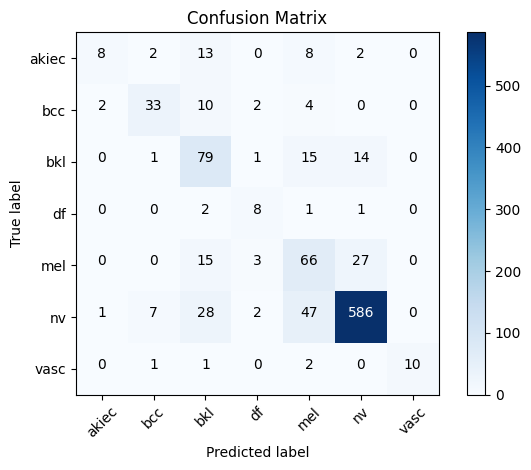

In [39]:
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [40]:
# Get the index of the class with the highest probability score
y_pred = np.argmax(predictions, axis=1)

# Get the labels of the test images.
y_true = test_batches.classes

In [42]:
# Generate a classification report
report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)



              precision    recall  f1-score   support

       akiec       0.73      0.24      0.36        33
         bcc       0.75      0.65      0.69        51
         bkl       0.53      0.72      0.61       110
          df       0.50      0.67      0.57        12
         mel       0.46      0.59      0.52       111
          nv       0.93      0.87      0.90       671
        vasc       1.00      0.71      0.83        14

    accuracy                           0.79      1002
   macro avg       0.70      0.64      0.64      1002
weighted avg       0.81      0.79      0.79      1002

